## Import TensorFlow and other libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import StandardScaler, Normalizer, PowerTransformer
from sklearn.model_selection import train_test_split
from tensorflow.keras import losses

import matplotlib.pyplot as plt

# Print tensorflow version. This code has been tested with 2.3.0
print(f'Tensorflow Version: {tf.__version__}')

Tensorflow Version: 2.3.0


## Restrict Tensorflow GPU memory usage

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

## Parameter definition

In [3]:
# Design id
#
# * 0: Non-linear front-end with ADC quantization
# * 1: Non-linear front-end without ADC quantization
# * 2: Linear front-end with ADC quantization
# * 3: Linear front-end without ADC quantization
id = 0
it = 1      # iteration

nrx = 16    # num of receiver antennas
nsnr = 11   # num of snr points
nx = 10000  # num of tx samples

## Read the data from the input files

In [4]:
# Read the randomly generated tx symbols
df = pd.read_csv(r'../../datasets/rx_1/idata_'+str(it)+'.csv')
x = np.char.replace(np.array(df['x'],dtype=str),'i','j').astype(np.complex)

# Read the channel w
w = np.array([np.char.replace(np.array(df['w_'+str(i+1)],dtype=str),'i','j').astype(np.complex)
              for i in range(nrx)], dtype=complex)

# Signal at each rx antenna.
y_ant = np.array([np.char.replace(np.array(df['yant_'+str(isnr*nrx+irx+1)],dtype=str),'i','j').astype(np.complex)
              for isnr in range(nsnr) for irx in range(nrx) ], dtype=complex).T.reshape(nx*nsnr,nrx)

# Read the output of the non-linear function
df = pd.read_csv(r'../../datasets/rx_1/odata_'+str(id+1)+'_'+str(it)+'.csv')
y_rffe = np.array([np.char.replace(np.array(df['yrffe_'+str(isnr*nrx+irx+1)],dtype=str),'i','j').astype(np.complex)
                    for isnr in range(nsnr) for irx in range(nrx)]).T.reshape(nx*nsnr,nrx)

# Read the estimated received symbols x_hat
x_hat = np.array([np.char.replace(np.array(df['xhat_'+str(i+1)],dtype=str),'i','j').astype(np.complex)
              for i in range(nsnr)], dtype=complex).T.reshape(-1,1)

# Read the input Power array in dBm
df = pd.read_csv(r'../../datasets/rx_1/param_1_'+str(id+1)+'_'+str(it)+'.csv')
power_in = df['Pin']

# Print the shape for some of the arrays
print(f'y_ant shape: {y_ant.shape}')
print(f'y_rffe shape: {y_rffe.shape}')

y_ant shape: (110000, 16)
y_rffe shape: (110000, 16)


## Define some helper functions

In [5]:
def snr(Phi):
    xh = sum(Phi.T*np.conj(w),0)/np.sum(np.abs(w)**2,0)
    a = np.mean(np.conj(xh)*x)/np.mean(np.abs(x)**2)
    d_var = np.mean(np.abs(xh - a*x)**2)
    snr_out = 10*np.log10(np.abs(a)**2/d_var)
    return snr_out

## Prepare the input data

In [6]:
r = np.hstack((y_ant.real, y_ant.imag))
X = np.hstack((y_rffe.real, y_rffe.imag))

x_train, x_test, y_train, y_test = train_test_split(X, r, shuffle=True, test_size=0.1)

scale_in = StandardScaler(with_mean=True, with_std=True).fit(X)
scale_out = StandardScaler(with_mean=True, with_std=True).fit(r)

x_train = scale_in.transform(x_train)
x_train = tf.constant(
    np.stack(
        (x_train[:,:16], x_train[:,16:]),
        axis=-1
    ),
    dtype=tf.float32
)

x_test = scale_in.transform(x_test)
x_test = tf.constant(
    np.stack(
        (x_test[:,:16], x_test[:,16:]),
        axis=-1
    ),
    dtype=tf.float32
)

y_train = scale_out.transform(y_train)
y_train = tf.constant(
    np.stack(
        (y_train[:,:16], y_train[:,16:]),
        axis=-1
    ),
    dtype=tf.float32
)

y_test = scale_out.transform(y_test)
y_test = tf.constant(
    np.stack(
        (y_test[:,:16], y_test[:,16:]),
        axis=-1
    ),
    dtype=tf.float32
)

print(f'x_train shape: {x_train.shape}')

x_train shape: (99000, 16, 2)


## Create a complex Dense Layer

In [7]:
class ComplexDense(tf.keras.layers.Layer):

    def __init__(self, units, activation=None, use_bias=True, **kwargs):
        super(ComplexDense, self).__init__(**kwargs)
        self.units = units
        self.use_bias = use_bias
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        w_init_real = tf.random_normal_initializer()
        w_init_imag = tf.random_normal_initializer()
        self.w_real = tf.Variable(
            initial_value=w_init_real(
                shape=(input_shape[1], self.units),
                dtype='float32'
            ),
            trainable=True
        )

        self.w_imag = tf.Variable(
            initial_value=w_init_imag(
                shape=(input_shape[1], self.units),
                dtype='float32'
            ),
            trainable=True
        )

        b_init = tf.random_normal_initializer()

        self.b = tf.Variable(
            initial_value=b_init(
                shape=(self.units,), dtype='float32'),
            trainable=True
        )

    def call(self, inputs):
        input_real = inputs[:, :, 0]
        input_imag = inputs[:, :, 1]
        out_real = tf.matmul(input_real, self.w_real) - tf.matmul(input_real, self.w_imag)
        out_imag = tf.matmul(input_imag, self.w_real) + tf.matmul(input_imag, self.w_imag)

        if self.use_bias:
            out_real = out_real + self.b
            out_imag = out_imag + self.b

        if self.activation is not None:
            out_real = self.activation(out_real)
            out_imag = self.activation(out_imag)

        output = tf.stack([out_real, out_imag], axis=-1)
        return output

## Create a custom loss layer

In [8]:
class ComplexLoss (tf.keras.losses.Loss):

    def __init__(self):
        super(ComplexLoss, self).__init__()

    def call(self, y_true, y_pred):
        y_pred = tf.complex(real=y_pred[:,:,0], imag=y_pred[:,:,1])
        y_true = tf.complex(real=y_true[:,:,0], imag=y_true[:,:,1])
        return tf.reduce_mean(tf.math.abs(y_pred - y_true) ** 2)

## Create the neural network model

In [9]:
model = tf.keras.Sequential([
    ComplexDense(16, activation='linear'),
    ComplexDense(32, activation='linear'),
    ComplexDense(64, activation='relu'),
    ComplexDense(128, activation='tanh'),
    ComplexDense(64, activation='relu'),
    ComplexDense(32, activation='linear'),
    ComplexDense(16, activation='linear')
])
sgdOpt = tf.keras.optimizers.SGD(
    learning_rate=0.05,
    momentum=0.5,
    nesterov=True
)

model.compile(
    optimizer=sgdOpt,
    loss=ComplexLoss())

model.fit(x_train, y_train,
          epochs=20,
          batch_size=100,
          shuffle=True,
          validation_data=(x_test,y_test))

Epoch 1/20
990/990 [==============================] - 2s 2ms/step - loss: 1.9853 - val_loss: 1.9206

## Measure the Performance

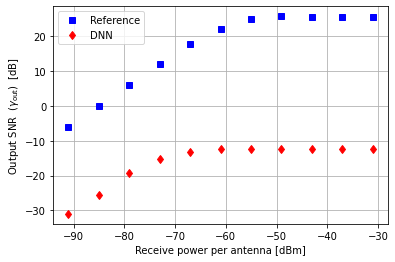

In [10]:
x_in = scale_in.transform(X)
x_in = tf.constant(
    np.stack((x_in[:,:16], x_in[:,16:]), axis=-1),
    dtype=tf.float32
)
pred = model(x_in).numpy()
pred = pred.reshape(nx*nsnr,-1)
pred = scale_out.inverse_transform(pred)
pred = pred[:,:16] + 1j*pred[:,16:]
pred = pred.reshape(nx, nsnr, nrx)

# Baseline data
base = y_rffe.reshape(nx, nsnr, nrx)

pred_snr = np.zeros(nsnr)
base_snr = np.zeros(nsnr)

for isnr in range(nsnr):
    pred_snr[isnr] = snr(pred[:,isnr,:])
    base_snr[isnr] = snr(base[:,isnr,:])

plt.plot(power_in, base_snr, 'bs')
plt.plot(power_in, pred_snr, 'rd')
plt.grid()
plt.xlabel('Receive power per antenna [dBm]')
plt.ylabel('Output SNR $\;(\gamma_\mathrm{out})\;$ [dB]')
plt.legend(['Reference', 'DNN'])
plt.show()